In [144]:
from model import LDM
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from NMI import NMI_advanced 

## Creating the Feature Mapping class

# Loading real data and saving indexes

In [255]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

#importing the data
f_vector = pd.read_csv('/Users/christine/LatentDistanceModel/data/feature_vector_combined.csv', sep=',')
f_vector.drop(columns=['base_id'], inplace=True)
feature_vector = pd.read_csv('/Users/christine/LatentDistanceModel/data/feature_vector.tsv', sep='\t')
feature_vector.drop(columns=['Unnamed: 0'], inplace=True)
feature_vector

torch.Size([745, 3677])


,0,Chewing gum,Inhal,Inhal.aerosol,Inhal.powder,Inhal.solution,N,O,P,R,...,V08AB05,V08AB06,V08AB07,V08AB09,V08CA03,V08CA04,V08CA06,V08CA08,V08CA09,V09AB03
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
#find indexing for the two vectors
adj_matrix_names = pd.read_csv('/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv', sep=',')
adj_matrix_idx = adj_matrix_names['Stitch flat']
adj_matrix_idx.to_csv('/Users/christine/LatentDistanceModel/data/adj_matrix_idx.csv', index=False)
adj_matrix_idx = adj_matrix_idx.to_numpy()

#index of feature vector
feature_vector_names = pd.read_csv('/Users/christine/LatentDistanceModel/data/feature_vector_names.tsv', sep = '\t', )
feature_vector_names['ID Adm.Rs'] = feature_vector_names['ID Adm.Rs'].str.split('_').str[0]
feature_vector_idx = feature_vector_names['ID Adm.Rs'].to_numpy()
adj_matrix_idx, feature_vector_idx

(array(['CID100000085', 'CID100000137', 'CID100000143', 'CID100000158',
        'CID100000159', 'CID100000160', 'CID100000191', 'CID100000214',
        'CID100000232', 'CID100000247', 'CID100000271', 'CID100000311',
        'CID100000444', 'CID100000450', 'CID100000453', 'CID100000581',
        'CID100000596', 'CID100000598', 'CID100000727', 'CID100000738',
        'CID100000750', 'CID100000772', 'CID100000861', 'CID100000937',
        'CID100000942', 'CID100001065', 'CID100001125', 'CID100001134',
        'CID100001301', 'CID100001546', 'CID100001690', 'CID100001775',
        'CID100001805', 'CID100001971', 'CID100001972', 'CID100001978',
        'CID100001983', 'CID100001990', 'CID100002019', 'CID100002022',
        'CID100002082', 'CID100002083', 'CID100002088', 'CID100002092',
        'CID100002094', 'CID100002099', 'CID100002118', 'CID100002130',
        'CID100002153', 'CID100002156', 'CID100002159', 'CID100002160',
        'CID100002161', 'CID100002162', 'CID100002170', 'CID1000

In [66]:
#for real data
Aij_dic = {drug_id: idx for idx, drug_id in enumerate(adj_matrix_idx)}
unique_drugs_Aij = pd.unique(adj_matrix_idx)
Aij_idx = np.array([Aij_dic[drug_id] for drug_id in adj_matrix_names['Stitch flat']])

#for feature vector
unique_drugs_f = pd.unique(feature_vector_idx)
f_dic = {drug_id: idx for idx, drug_id in enumerate(unique_drugs_f)}
f_idx = np.array([f_dic[drug_id] for drug_id in feature_vector_names['ID Adm.Rs']])
Aij_idx, f_idx

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [65]:
#ensure consistency across datasets
only_in_Aij = set(unique_drugs_Aij) - set(unique_drugs_f)
only_in_f = set(unique_drugs_f) - set(unique_drugs_Aij)
not_in_both = only_in_Aij.union(only_in_f)
print(f"Only in Aij: {only_in_Aij}\nOnly in feature vector: {only_in_f}\nNot in either: {not_in_both}")
print(f"{len(only_in_Aij)} are missing from feature vector")

Only in Aij: set()
Only in feature vector: set()
Not in either: set()
0 are missing from feature vector


In [67]:
#convert to tensor
feature_tensor = torch.tensor(feature_vector.astype(np.float32).to_numpy(), dtype=torch.float32)

## Training the model

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()


/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5310
Epoch 1/300, Loss: 3.4891
Epoch 2/300, Loss: 3.4480
Epoch 3/300, Loss: 3.4076
Epoch 4/300, Loss: 3.3679
Epoch 5/300, Loss: 3.3291
Epoch 6/300, Loss: 3.2914
Epoch 7/300, Loss: 3.2546
Epoch 8/300, Loss: 3.2188
Epoch 9/300, Loss: 3.1833
Epoch 10/300, Loss: 3.1480
Epoch 11/300, Loss: 3.1121
Epoch 12/300, Loss: 3.0756
Epoch 13/300, Loss: 3.0392
Epoch 14/300, Loss: 3.0032
Epoch 15/300, Loss: 2.9678
Epoch 16/300, Loss: 2.9329
Epoch 17/300, Loss: 2.8986
Epoch 18/300, Loss: 2.8648
Epoch 19/300, Loss: 2.8311
Epoch 20/300, Loss: 2.7969
Epoch 21/300, Loss: 2.7618
Epoch 22/300, Loss: 2.7258
Epoch 23/300, Loss: 2.6900
Epoch 24/300, Loss: 2.6543
Epoch 25/300, Loss: 2.6184
Epoch 26/300, Loss: 2.5822
Epoch 27/300, Loss: 2.5466
Epoch 28/300, Loss: 2.5123
Epoch 29/300, Loss: 2.4799
Epoch 30/300, Loss: 2.4494
Epoch 31/300, Loss: 2.4204
Epoch 32/300, Loss: 2.3926
Epoch 33/300, Loss: 2.3655
Epoch 34/300, Loss: 2.3389
Epoch 35/300, Loss: 2.3121
Epoch 36/300, Loss: 2.2852
Epoch 37/30

In [9]:
beta = ldm_trained_r.beta.detach()
gamma = ldm_trained_r.gamma.detach()

In [ ]:
class FeatureMapper(nn.Module):
    def __init__(self, input_dim, embedding_dim, start_gamma, dropout = 0.1):
        super(FeatureMapper, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.zi = nn.Linear(16, embedding_dim)
        self.gammai = nn.Linear(16, 1) 
    def forward(self, x):
        hidden = self.feature_net(x)
        z_i = self.zi(hidden)
        gamma_i = self.gammai(hidden).squeeze(-1)  # shape: (batch,) or (1,)
        return z_i, gamma_i

In [69]:
mapper = FeatureMapper(input_dim=feature_vector.shape[1], embedding_dim=w_r.shape[1], start_gamma=gamma)
optimizer = torch.optim.Adam(mapper.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 100

w_frozen = ldm_trained_r.w.detach().clone()
feature_vec_tensor = torch.tensor(feature_vector.astype(np.float32).to_numpy(), dtype=torch.float32)
feature_idx_tensor = torch.tensor(f_idx, dtype=torch.long)
w_tensor = torch.tensor(w_r, dtype=torch.float32)

for epoch in range(num_epochs):
    mapper.train()
    optimizer.zero_grad()

    z_pred, beta_pred = mapper(feature_vec_tensor)
    z_true = w_tensor[feature_idx_tensor]

    loss = loss_fn(z_pred, z_true) 
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 6.2710
Epoch 1, Loss: 5.0018
Epoch 2, Loss: 3.9821
Epoch 3, Loss: 2.6240
Epoch 4, Loss: 2.4325
Epoch 5, Loss: 2.0116
Epoch 6, Loss: 1.6735
Epoch 7, Loss: 1.6374
Epoch 8, Loss: 1.3725
Epoch 9, Loss: 1.3452
Epoch 10, Loss: 1.2459
Epoch 11, Loss: 1.2329
Epoch 12, Loss: 1.1568
Epoch 13, Loss: 1.1033
Epoch 14, Loss: 1.1328
Epoch 15, Loss: 1.0687
Epoch 16, Loss: 1.0568
Epoch 17, Loss: 1.0401
Epoch 18, Loss: 1.0648
Epoch 19, Loss: 1.0519
Epoch 20, Loss: 1.0285
Epoch 21, Loss: 1.0228
Epoch 22, Loss: 1.0073
Epoch 23, Loss: 1.0137
Epoch 24, Loss: 1.0079
Epoch 25, Loss: 1.0070
Epoch 26, Loss: 1.0152
Epoch 27, Loss: 1.0288
Epoch 28, Loss: 1.0275
Epoch 29, Loss: 1.0055
Epoch 30, Loss: 0.9966
Epoch 31, Loss: 0.9956
Epoch 32, Loss: 1.0028
Epoch 33, Loss: 1.0081
Epoch 34, Loss: 1.0013
Epoch 35, Loss: 1.0009
Epoch 36, Loss: 0.9858
Epoch 37, Loss: 0.9839
Epoch 38, Loss: 0.9785
Epoch 39, Loss: 0.9776
Epoch 40, Loss: 0.9831
Epoch 41, Loss: 0.9790
Epoch 42, Loss: 0.9745
Epoch 43, Loss: 0.976

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/1644378400.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_tensor = torch.tensor(w_r, dtype=torch.float32)


# End to end

In [38]:
class EndToEnd(nn.Module):
    def __init__(self, feature_mapper, v, gamma, beta, beta_thilde, a, b, Aij, device):
        super().__init__()
        self.feature_mapper = feature_mapper
        self.v = nn.Parameter(v.clone())
        self.gamma = nn.Parameter(gamma.clone()) 
        self.beta = nn.Parameter(beta.clone())  
        self.beta_thilde = nn.Parameter(beta_thilde.clone())  
        self.a = nn.Parameter(a.clone())
        self.b = nn.Parameter(b.clone())

        self.Aij = Aij
        self.device = device
        self.n_ordinal_classes = Aij.max().int().item() + 1
        self.n_drugs, self.n_effects = Aij.shape

    def get_thresholds(self):
        # reused from LDM
        deltas = torch.softmax(self.beta_thilde, dim = 0)  
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def forward(self, feature_vector, Aij_batch = None, predicting =False):
        z_i, gamma_i = self.feature_mapper(feature_vector)
        thresholds = self.get_thresholds()
        normal_dist = Normal(0, 1)

        if predicting:
            dist = -torch.norm(z_i.unsqueeze(1) - self.v.unsqueeze(0), dim=2)
            linear_term = gamma_i.unsqueeze(1) + self.beta.unsqueeze(0)
            latent_var = linear_term + dist
            probit_matrix = torch.stack([
                normal_dist.cdf(latent_var - thresholds[y]) - normal_dist.cdf(latent_var - thresholds[y+1])
                for y in range(self.n_ordinal_classes)
            ])
            return probit_matrix  # shape: [n_classes, n_new_drugs, n_effects]
        else:
            dist = -torch.norm(z_i.unsqueeze(1) - self.v.unsqueeze(0), dim=2)
            linear_term = gamma_i.unsqueeze(1) + self.beta.unsqueeze(0)
            latent_var = linear_term + dist
            probit_matrix = torch.stack([
                normal_dist.cdf(latent_var - thresholds[y]) - normal_dist.cdf(latent_var - thresholds[y+1])
                for y in range(self.n_ordinal_classes)
            ])
            return probit_matrix 
    
    def ordinal_cross_entropy_loss(self, probit_matrix, Aij_actual):
    # Compute the predicted probabilities using the probit function
        n_drugs, n_effects = Aij_actual.shape  # dynamically determine sizes

        one_hot_target = torch.zeros(n_drugs, n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, Aij_actual.unsqueeze(-1).long(), 1)

        # permute to match probit_matrix shape and compute loss
        prob = probit_matrix
        prob = prob[:, :n_drugs, :]
        loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        return loss
    
    def _get_learned_params(self):
        return self.v, self.gamma, self.beta, self.beta_thilde, self.a, self.b

In [39]:
beta = ldm_trained_r.beta.detach().cpu()
beta.shape

torch.Size([3677])

In [70]:
v = ldm_trained_r.v.detach().cpu()
v.shape

torch.Size([3677, 15])

In [41]:
# Assume Aij_train is a subset of the original Aij
feature_tensor_train = torch.tensor(f_vector.values, dtype=torch.float32, device=device)
Aij_tensor_train = torch.tensor(Aij_real, dtype=torch.float32, device=device)
v = ldm_trained_r.v.detach().cpu()
gamma = ldm_trained_r.gamma.detach().cpu()
beta = ldm_trained_r.beta.detach().cpu()
beta_thilde = ldm_trained_r.beta_thilde.detach().cpu()
a = ldm_trained_r.a.detach().cpu()
b = ldm_trained_r.b.detach().cpu()

model = EndToEnd(
    feature_mapper=FeatureMapper(feature_tensor.shape[1], embedding_dim=w_r.shape[1], start_gamma=gamma).to(device),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_real,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    model.train()
    optimizer.zero_grad()

    probits = model(feature_tensor_train, Aij_batch=Aij_tensor_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_real)
    loss.backward()
    optimizer.step()

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/1997598145.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor_train = torch.tensor(Aij_real, dtype=torch.float32, device=device)


# Evaluation

### Making training, test and validation set

In [15]:
import random

In [45]:
n_drugs = Aij_real.shape[0]
indices = list(range(n_drugs))
random.shuffle(indices)

split = int(0.8 * n_drugs)
train_rows = indices[:split]
test_rows = indices[split:]

Aij_train = Aij_real[train_rows, :]
Aij_test = Aij_real[test_rows, :]

In [58]:
def create_splits(indices, num_splits=5, seed=42):
    np.random.seed(seed)
    indices = np.array(indices)
    np.random.shuffle(indices)
    split_size = len(indices) // num_splits
    splits = []
    for i in range(num_splits):
        test_idx = indices[i*split_size:(i+1)*split_size]
        train_idx = np.setdiff1d(indices, test_idx)
        splits.append((train_idx, test_idx))
    return splits


In [101]:
def evaluate_feature_mapper(ldm_model, f_vec, f_vec_idx, w, 
                            n_splits=5, num_epochs=100, learning_rate=0.001, splits=None):
    class FeatureMapper(nn.Module):
        def __init__(self, input_dim, embedding_dim, start_gamma=None, dropout=0.1):
            super(FeatureMapper, self).__init__()
            self.input_dim = input_dim
            self.embedding_dim = embedding_dim

            self.feature_net = nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Dropout(dropout),
            )
            self.zi = nn.Linear(16, embedding_dim)
            self.gammai = nn.Linear(16, 1)

        def forward(self, x):
            hidden = self.feature_net(x)
            z_i = self.zi(hidden)
            gamma_i = self.gammai(hidden).squeeze(-1)
            return z_i, gamma_i

    f_vec_tensor = torch.tensor(f_vec, dtype=torch.float32)
    drug_idx_tensor = torch.tensor(f_vec_idx, dtype=torch.long)
    w_tensor = w.clone().detach().float() if isinstance(w, torch.Tensor) else torch.tensor(w, dtype=torch.float32)

    test_losses = []
    cosine_sims = []
    pearson_corrs = []
    spearman_corrs = []

    for split in range(n_splits):
        print(f"\nSplit {split + 1}/{n_splits}")

        train_idx, test_idx = splits[split]

        # Training data
        f_vec_train = f_vec_tensor[train_idx]
        z_true_train = w_tensor[f_vec_idx[train_idx]]

        # Test data
        f_vec_test = f_vec_tensor[test_idx]
        z_true_test = w_tensor[f_vec_idx[test_idx]]

        mapper = FeatureMapper(
            input_dim=f_vec.shape[1],
            embedding_dim=w.shape[1],
            start_gamma=ldm_model.gamma.detach().clone() if hasattr(ldm_model, "gamma") else None
        )

        optimizer = torch.optim.Adam(mapper.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()

        # Train loop
        for epoch in range(num_epochs):
            mapper.train()
            optimizer.zero_grad()
            z_pred_train, _ = mapper(f_vec_train)
            loss = loss_fn(z_pred_train, z_true_train)
            loss.backward()
            optimizer.step()

        # Eval
        mapper.eval()
        with torch.no_grad():
            z_pred_test, _ = mapper(f_vec_test)
            test_loss = loss_fn(z_pred_test, z_true_test).item()
            test_losses.append(test_loss)

            z_pred_np = z_pred_test.cpu().numpy()
            z_true_np = z_true_test.cpu().numpy()

            # Cosine similarity
            cos_sim = np.mean(np.diag(cosine_similarity(z_pred_np, z_true_np)))
            cosine_sims.append(cos_sim)

            # Pearson and Spearman correlation
            pearson_corr, _ = pearsonr(z_pred_np.flatten(), z_true_np.flatten())
            spearman_corr, _ = spearmanr(z_pred_np.flatten(), z_true_np.flatten())
            pearson_corrs.append(pearson_corr)
            spearman_corrs.append(spearman_corr)

            print(f"Split {split + 1}: MSE={test_loss:.4f}, CosSim={cos_sim:.4f}, "
                  f"Pearson={pearson_corr:.4f}, Spearman={spearman_corr:.4f}")

    # Summary
    mean_loss = np.mean(test_losses)
    std_loss = np.std(test_losses)
    print(f"\nMean Test MSE: {mean_loss:.4f} ± {std_loss:.4f}")
    print(f"Mean Cosine Similarity: {np.mean(cosine_sims):.4f}")
    print(f"Mean Pearson Corr: {np.mean(pearson_corrs):.4f}")
    print(f"Mean Spearman Corr: {np.mean(spearman_corrs):.4f}")

    return {
        'mse_mean': mean_loss,
        'mse_std': std_loss,
        'mse_all': test_losses,
        'cosine_sim': cosine_sims,
        'pearson_corr': pearson_corrs,
        'spearman_corr': spearman_corrs
    }

In [102]:
splits = create_splits(np.arange(len(f_vector)), num_splits=5)

results = evaluate_feature_mapper(
    ldm_model=ldm_trained_r,
    f_vec=f_vector.to_numpy(),
    f_vec_idx=f_idx,
    w=w_r,
    n_splits=5,
    num_epochs=300,
    learning_rate=0.01,
    splits = splits
)

print("Mean MSE:", results["mse_mean"])
print("Mean Cosine Similarity:", np.mean(results["cosine_sim"]))
print("Mean Pearsons:", np.mean(results["pearson_corr"]))


Split 1/5
Split 1: MSE=1.1062, CosSim=-0.0260, Pearson=0.0010, Spearman=-0.0178

Split 2/5
Split 2: MSE=1.0796, CosSim=0.0518, Pearson=0.0439, Spearman=0.0449

Split 3/5
Split 3: MSE=1.0615, CosSim=0.0184, Pearson=0.0163, Spearman=0.0194

Split 4/5
Split 4: MSE=1.0475, CosSim=0.0349, Pearson=0.0250, Spearman=0.0384

Split 5/5
Split 5: MSE=1.0327, CosSim=0.0068, Pearson=-0.0127, Spearman=-0.0192

Mean Test MSE: 1.0655 ± 0.0256
Mean Cosine Similarity: 0.0172
Mean Pearson Corr: 0.0147
Mean Spearman Corr: 0.0131
Mean MSE: 1.065507459640503
Mean Cosine Similarity: 0.017166432
Mean Pearsons: 0.014714244


In [79]:
def evaluate_feature_mapper(ldm_model, f_vec, f_vec_idx, w, n_splits=5, num_epochs=100, learning_rate=0.001, splits=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class FeatureMapper(nn.Module):
        def __init__(self, input_dim, embedding_dim, dropout=0.1):
            super(FeatureMapper, self).__init__()
            self.feature_net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.zi = nn.Linear(16, embedding_dim)
            self.gammai = nn.Linear(16, 1)

        def forward(self, x):
            hidden = self.feature_net(x)
            z_i = self.zi(hidden)
            gamma_i = self.gammai(hidden).squeeze(-1)
            return z_i, gamma_i

    # Convert inputs to torch tensors
    f_vec_tensor = torch.tensor(f_vec, dtype=torch.float32, device=device)
    w_tensor = torch.tensor(w, dtype=torch.float32, device=device)

    # Store test losses and cosine similarities
    test_losses = []
    cosine_sims = []

    # Create splits if not provided
    if splits is None:
        indices = np.arange(len(f_vec))
        np.random.shuffle(indices)
        split_size = len(f_vec) // n_splits
        splits = []
        for i in range(n_splits):
            test_idx = indices[i*split_size:(i+1)*split_size]
            train_idx = np.setdiff1d(indices, test_idx)
            splits.append((train_idx, test_idx))

    for train_idx, test_idx in splits:
        # Prepare data
        f_vec_train = f_vec_tensor[train_idx]
        z_true_train = w_tensor[train_idx]
        f_vec_test = f_vec_tensor[test_idx]
        z_true_test = w_tensor[test_idx]

        # Initialize model
        input_dim = f_vec.shape[1]
        embedding_dim = w.shape[1]
        mapper = FeatureMapper(input_dim=input_dim, embedding_dim=embedding_dim).to(device)
        optimizer = torch.optim.Adam(mapper.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Train
        for epoch in range(num_epochs):
            mapper.train()
            optimizer.zero_grad()
            z_pred_train, _ = mapper(f_vec_train)
            loss = criterion(z_pred_train, z_true_train)
            loss.backward()
            optimizer.step()

        # Evaluate
        mapper.eval()
        with torch.no_grad():
            z_pred_test, _ = mapper(f_vec_test)
            loss = criterion(z_pred_test, z_true_test).item()

            z_pred_np = z_pred_test.cpu().numpy()
            z_true_np = z_true_test.cpu().numpy()

            cos_sim = np.mean(np.diag(cosine_similarity(z_pred_np, z_true_np)))

        test_losses.append(loss)
        cosine_sims.append(cos_sim)

    return {
        "mse_mean": np.mean(test_losses),
        "mse_std": np.std(test_losses),
        "cosine_sim": cosine_sims
    }

In [80]:
results = evaluate_feature_mapper(
    ldm_model=ldm_trained_r,       # your trained LDM model
    f_vec=f_vector.to_numpy(),     # features as NumPy array
    f_vec_idx=f_idx,               # row indices (e.g., drug IDs)
    w=w_r,                         # learned latent positions
    n_splits=5,
    num_epochs=300,
    learning_rate=0.001,
    splits=splits                  # if you have predefined train/test splits
)

print(results)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/1061272409.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_tensor = torch.tensor(w, dtype=torch.float32, device=device)


{'mse_mean': np.float64(1.0691574096679688), 'mse_std': np.float64(0.027327873392180423), 'cosine_sim': [np.float32(0.014523805), np.float32(0.01904513), np.float32(0.0074062333), np.float32(0.0016635824), np.float32(-0.013630934)]}


In [81]:
def evaluate_EndToEnd(f_vector, Aij_real, f_vec_idx, ldm_trained, n_splits=5, num_epochs=20, lr=0.01, splits= None):
    Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
    feat_vec = feature_tensor[f_idx]
    f_vec_tensor = torch.tensor(f_vector.values, dtype=torch.float32, device=device)
    f_idx_tensor = torch.tensor(f_idx, dtype=torch.long)

    v = ldm_trained_r.v.detach().cpu()
    gamma = ldm_trained_r.gamma.detach().cpu()
    beta = ldm_trained_r.beta.detach().cpu()
    beta_thilde = ldm_trained_r.beta_thilde.detach().cpu()
    a = ldm_trained_r.a.detach().cpu()
    b = ldm_trained_r.b.detach().cpu()

    mses, cosines, pearsons, spearmans, nmis = [],[],[],[], []
    for split in range(n_splits):
        print(f"\n Split {split + 1}/{n_splits}")
        train_idx, test_idx = splits[split]

        f_train = f_vec_tensor[train_idx]
        f_test = f_vec_tensor[test_idx]
        drug_train_idx = f_idx_tensor[train_idx]
        drug_test_idx = f_idx_tensor[test_idx]

        Aij_train = Aij_tensor[drug_train_idx]  # (n_train, n_effects)
        Aij_test = Aij_tensor[drug_test_idx]

        model = EndToEnd(
            feature_mapper=FeatureMapper(feature_tensor.shape[1], embedding_dim=w_r.shape[1], start_beta=beta).to(device),
            v=ldm_trained_r.v,
            gamma=ldm_trained_r.gamma,
            beta=ldm_trained_r.beta,
            beta_thilde=ldm_trained_r.beta_thilde,
            a=ldm_trained_r.a,
            b=ldm_trained_r.b,
            Aij=Aij_train,
            device=device
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            probits = model(f_train, Aij_batch=Aij_train)
            loss = model.ordinal_cross_entropy_loss(probits)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_probits = model(f_test, predicting=True)
        pred_scores = torch.argmax(pred_probits, dim=0).cpu().numpy()
        true_scores = Aij_test.cpu().numpy()

        #computing NMI
        true_probits = F.one_hot(Aij_test.long(), num_classes=pred_probits.shape[0]).permute(2, 0, 1).float()
        nmi, joint = NMI_advanced(true_probits, pred_probits)
        nmis.append(nmi)    

        pred_flat = pred_scores.flatten()
        true_flat = true_scores.flatten()

        mse = mean_squared_error(true_flat, pred_flat)
        cosine = F.cosine_similarity(torch.tensor(pred_flat), torch.tensor(true_flat), dim=0).item()
        pearson_corr = pearsonr(true_flat, pred_flat)[0]
        spearman_corr = spearmanr(true_flat, pred_flat)[0]

        mses.append(mse)
        cosines.append(cosine)
        pearsons.append(pearson_corr)
        spearmans.append(spearman_corr)

        print(f"Split {split+1} — MSE: {mse:.4f}, Cosine: {cosine:.4f}, Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}")

    # Summary
    print(f"Mean MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")
    print(f"Mean Cosine Similarity: {np.mean(cosines):.4f}")
    print(f"Mean Pearson Corr: {np.mean(pearsons):.4f}")
    print(f"Mean Spearman Corr: {np.mean(spearmans):.4f}")
    print(f"Mean NMI: {np.mean(nmis):.4f}")

    return {
        'mse': mses,
        'cosine': cosines,
        'pearson': pearsons,
        'spearman': spearmans,
        'nmi': nmis
    }

In [96]:
def evaluate_EndToEnd(f_vector, Aij_real, f_vec_idx, ldm_trained, n_splits=5, num_epochs=20, lr=0.01, splits=None):

    # Prepare tensors
    Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
    f_vec_tensor = torch.tensor(f_vector.values, dtype=torch.float32, device=device)
    f_idx_tensor = torch.tensor(f_vec_idx, dtype=torch.long, device=device)

    # Extract LDM components (detach for safety, use on CPU for evaluation metrics)
    v = ldm_trained.v.detach()
    gamma = ldm_trained.gamma.detach()
    beta = ldm_trained.beta.detach()
    beta_thilde = ldm_trained.beta_thilde.detach()
    a = ldm_trained.a.detach()
    b = ldm_trained.b.detach()

    # Tracking metrics
    mses, cosines, pearsons, spearmans, nmis = [], [], [], [], []

    for split in range(n_splits):
        print(f"\nSplit {split + 1}/{n_splits}")
        train_idx, test_idx = splits[split]

        # Subset features and indices
        f_train = f_vec_tensor[train_idx]
        f_test = f_vec_tensor[test_idx]
        drug_train_idx = f_idx_tensor[train_idx]
        drug_test_idx = f_idx_tensor[test_idx]

        Aij_train = Aij_tensor[drug_train_idx]
        Aij_test = Aij_tensor[drug_test_idx]

        # Initialize model
        model = EndToEnd(
            feature_mapper=FeatureMapper(
            f_vec_tensor.shape[1],
                embedding_dim=v.shape[1],
                start_gamma=gamma.to(device)
            ).to(device),
            v=v.to(device),
            gamma=gamma.to(device),
            beta=beta.to(device),
            beta_thilde=beta_thilde.to(device),
            a=a.to(device),
            b=b.to(device),
            Aij=Aij_train,
            device=device
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            probits = model(f_train, Aij_batch=Aij_train)
            loss = model.ordinal_cross_entropy_loss(probits, Aij_train) 
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            pred_probits = model(f_test, predicting=True)
            pred_scores = torch.argmax(pred_probits, dim=0).cpu().numpy()
            true_scores = Aij_test.cpu().numpy()

            # Compute NMI
            true_probits = F.one_hot(Aij_test.long(), num_classes=pred_probits.shape[0]).permute(2, 0, 1).float()
            nmi, _ = NMI_advanced(true_probits, pred_probits)
            nmis.append(nmi)

            # Flatten scores
            pred_flat = pred_scores.flatten()
            true_flat = true_scores.flatten()

            mse = mean_squared_error(true_flat, pred_flat)
            cosine = F.cosine_similarity(torch.tensor(pred_flat), torch.tensor(true_flat), dim=0).item()
            pearson_corr = pearsonr(true_flat, pred_flat)[0]
            spearman_corr = spearmanr(true_flat, pred_flat)[0]

            mses.append(mse)
            cosines.append(cosine)
            pearsons.append(pearson_corr)
            spearmans.append(spearman_corr)

            print(f"Split {split+1} — MSE: {mse:.4f}, Cosine: {cosine:.4f}, Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}, NMI: {nmi:.4f}")

    # Summary
    print(f"\nSummary:")
    print(f"Mean MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")
    print(f"Mean Cosine Similarity: {np.mean(cosines):.4f}")
    print(f"Mean Pearson Corr: {np.mean(pearsons):.4f}")
    print(f"Mean Spearman Corr: {np.mean(spearmans):.4f}")
    print(f"Mean NMI: {np.mean(nmis):.4f}")

    return {
        'mse': mses,
        'cosine': cosines,
        'pearson': pearsons,
        'spearman': spearmans,
        'nmi': nmis
    }


In [98]:
results = evaluate_EndToEnd(
    f_vector=feature_vector,
    Aij_real=Aij_real,
    f_vec_idx=f_idx,
    ldm_trained=ldm_trained_r,
    n_splits=5,
    num_epochs=200,
    lr=0.01,
    splits=splits
)


/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/3603715226.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)



Split 1/5
Split 1 — MSE: 0.1135, Cosine: 0.3122, Pearson: 0.3068, Spearman: 0.2638, NMI: 0.0734

Split 2/5
Split 2 — MSE: 0.1054, Cosine: 0.3021, Pearson: 0.2972, Spearman: 0.2459, NMI: 0.0701

Split 3/5
Split 3 — MSE: 0.0967, Cosine: 0.3198, Pearson: 0.3148, Spearman: 0.2708, NMI: 0.0735

Split 4/5
Split 4 — MSE: 0.1066, Cosine: 0.3081, Pearson: 0.3025, Spearman: 0.2570, NMI: 0.0733

Split 5/5
Split 5 — MSE: 0.1065, Cosine: 0.2894, Pearson: 0.2850, Spearman: 0.2398, NMI: 0.0679

Summary:
Mean MSE: 0.1057 ± 0.0054
Mean Cosine Similarity: 0.3063
Mean Pearson Corr: 0.3012
Mean Spearman Corr: 0.2555
Mean NMI: 0.0717


## Removing row and predict the row

In [188]:
removed_row_idx = 0

Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
Aij_true = Aij_tensor[removed_row_idx].clone()

#Remove from the dataframe
Aij_train = torch.cat([Aij_tensor[:removed_row_idx], Aij_tensor[removed_row_idx+1:]], dim=0)

#Remove from the feature vector
f_tensor = torch.tensor(feature_vector.values, dtype=torch.float32, device=device)
f_train = torch.cat([f_tensor[:removed_row_idx], f_tensor[removed_row_idx+1:]], dim=0)
f_test = f_tensor[removed_row_idx].unsqueeze(0)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/237585836.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)


In [218]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_train, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5269
Epoch 1/300, Loss: 3.4847
Epoch 2/300, Loss: 3.4432
Epoch 3/300, Loss: 3.4022
Epoch 4/300, Loss: 3.3620
Epoch 5/300, Loss: 3.3225
Epoch 6/300, Loss: 3.2839
Epoch 7/300, Loss: 3.2464
Epoch 8/300, Loss: 3.2099
Epoch 9/300, Loss: 3.1743
Epoch 10/300, Loss: 3.1390
Epoch 11/300, Loss: 3.1032
Epoch 12/300, Loss: 3.0671
Epoch 13/300, Loss: 3.0310
Epoch 14/300, Loss: 2.9952
Epoch 15/300, Loss: 2.9599
Epoch 16/300, Loss: 2.9249
Epoch 17/300, Loss: 2.8905
Epoch 18/300, Loss: 2.8565
Epoch 19/300, Loss: 2.8225
Epoch 20/300, Loss: 2.7878
Epoch 21/300, Loss: 2.7521
Epoch 22/300, Loss: 2.7159
Epoch 23/300, Loss: 2.6798
Epoch 24/300, Loss: 2.6439
Epoch 25/300, Loss: 2.6076
Epoch 26/300, Loss: 2.5712
Epoch 27/300, Loss: 2.5355
Epoch 28/300, Loss: 2.5013
Epoch 29/300, Loss: 2.4690
Epoch 30/300, Loss: 2.4385
Epoch 31/300, Loss: 2.4094
Epoch 32/300, Loss: 2.3815
Epoch 33/300, Loss: 2.3542
Epoch 34/300, Loss: 2.3272
Epoch 35/300, Loss: 2.3000
Epoch 36/300, Loss: 2.2728
Epoch 37/30

In [219]:
model = EndToEnd(
    feature_mapper=FeatureMapper(input_dim=f_tensor.shape[1], embedding_dim=ldm_trained_r.v.shape[1], start_gamma = gamma),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_train,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    probits = model(f_train, Aij_batch=Aij_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_train)
    loss.backward()
    optimizer.step()


In [221]:
model.eval()
with torch.no_grad():
    probits_pred = model(f_test, predicting=True) 
    predictions = torch.argmax(probits_pred.squeeze(1), dim=0)

In [222]:
true = Aij_true.cpu().numpy()
pred = predictions.cpu().numpy()

mse = mean_squared_error(true, pred)

#count of how many correct links
correct_links = np.sum(pred==true)
total_links = len(true)
accuracy = accuracy_score(true, pred)

print(f"Evaluation for held-out drug:")
print(f"MSE: {mse:.4f}")
print(f"Correct Predictions: {correct_links}/{total_links}")
print(f"Accuracy: {accuracy:.4f}")


Evaluation for held-out drug:
MSE: 0.1428
Correct Predictions: 3548/3677
Accuracy: 0.9649


In [223]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true, pred)) if t != p]
for i in misclassified_indices:
    print(f"True value: {true[i]}, Predicted:{pred[i]}")

True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:3
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 0.0, Predicted:3
True value: 2.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.

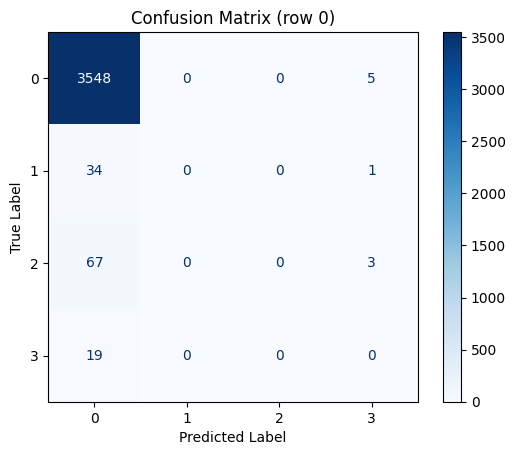

In [225]:
# Compute the confusion matrix
cm = confusion_matrix(true, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (row 0)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### New index (removing row 14)

In [226]:
removed_row_idx = 14

Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
Aij_true = Aij_tensor[removed_row_idx].clone()

#Remove from the dataframe
Aij_train = torch.cat([Aij_tensor[:removed_row_idx], Aij_tensor[removed_row_idx+1:]], dim=0)

#Remove from the feature vector
f_tensor = torch.tensor(feature_vector.values, dtype=torch.float32, device=device)
f_train = torch.cat([f_tensor[:removed_row_idx], f_tensor[removed_row_idx+1:]], dim=0)
f_test = f_tensor[removed_row_idx].unsqueeze(0)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/3821469945.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)


In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_train, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5534
Epoch 1/300, Loss: 3.5141
Epoch 2/300, Loss: 3.4751
Epoch 3/300, Loss: 3.4364
Epoch 4/300, Loss: 3.3981
Epoch 5/300, Loss: 3.3598
Epoch 6/300, Loss: 3.3216
Epoch 7/300, Loss: 3.2836
Epoch 8/300, Loss: 3.2460
Epoch 9/300, Loss: 3.2092
Epoch 10/300, Loss: 3.1728
Epoch 11/300, Loss: 3.1362
Epoch 12/300, Loss: 3.0989
Epoch 13/300, Loss: 3.0608
Epoch 14/300, Loss: 3.0225
Epoch 15/300, Loss: 2.9841
Epoch 16/300, Loss: 2.9461
Epoch 17/300, Loss: 2.9084
Epoch 18/300, Loss: 2.8715
Epoch 19/300, Loss: 2.8353
Epoch 20/300, Loss: 2.7998
Epoch 21/300, Loss: 2.7640
Epoch 22/300, Loss: 2.7276
Epoch 23/300, Loss: 2.6909
Epoch 24/300, Loss: 2.6543
Epoch 25/300, Loss: 2.6183
Epoch 26/300, Loss: 2.5829
Epoch 27/300, Loss: 2.5480
Epoch 28/300, Loss: 2.5136
Epoch 29/300, Loss: 2.4800
Epoch 30/300, Loss: 2.4475
Epoch 31/300, Loss: 2.4160
Epoch 32/300, Loss: 2.3852
Epoch 33/300, Loss: 2.3551
Epoch 34/300, Loss: 2.3259
Epoch 35/300, Loss: 2.2974
Epoch 36/300, Loss: 2.2699
Epoch 37/30

In [228]:
model = EndToEnd(
    feature_mapper=FeatureMapper(input_dim=f_tensor.shape[1], embedding_dim=ldm_trained_r.v.shape[1], start_gamma = gamma),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_train,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    probits = model(f_train, Aij_batch=Aij_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_train)
    loss.backward()
    optimizer.step()


In [229]:
model.eval()
with torch.no_grad():
    probits_pred = model(f_test, predicting=True) 
    predictions = torch.argmax(probits_pred.squeeze(1), dim=0)

In [230]:
true = Aij_true.cpu().numpy()
pred = predictions.cpu().numpy()

mse = mean_squared_error(true, pred)

#count of how many correct links
correct_links = np.sum(pred==true)
total_links = len(true)
accuracy = accuracy_score(true, pred)

print(f"Evaluation for held-out drug:")
print(f"MSE: {mse:.4f}")
print(f"Correct Predictions: {correct_links}/{total_links}")
print(f"Accuracy: {accuracy:.4f}")


Evaluation for held-out drug:
MSE: 0.0729
Correct Predictions: 3644/3677
Accuracy: 0.9910


In [231]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true, pred)) if t != p]
for i in misclassified_indices:
    print(f"True value: {true[i]}, Predicted:{pred[i]}")

True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 0.0, Predicted:3
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 0.0, Predicted:3
True value: 1.0, Predicted:0
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 3.0, Predicted:0
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0


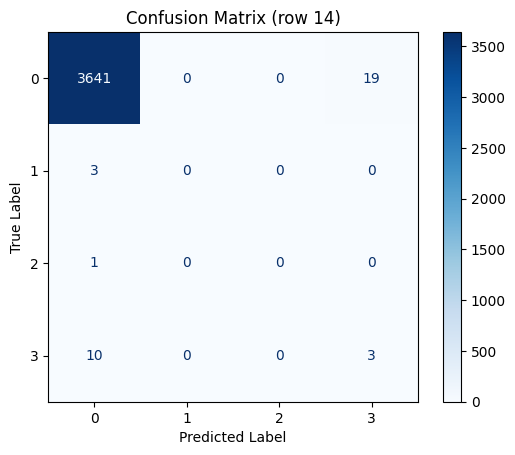

In [232]:
# Compute the confusion matrix
cm = confusion_matrix(true, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (row 14)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### New index (removing row 134)

In [233]:
removed_row_idx = 134

Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
Aij_true = Aij_tensor[removed_row_idx].clone()

#Remove from the dataframe
Aij_train = torch.cat([Aij_tensor[:removed_row_idx], Aij_tensor[removed_row_idx+1:]], dim=0)

#Remove from the feature vector
f_tensor = torch.tensor(feature_vector.values, dtype=torch.float32, device=device)
f_train = torch.cat([f_tensor[:removed_row_idx], f_tensor[removed_row_idx+1:]], dim=0)
f_test = f_tensor[removed_row_idx].unsqueeze(0)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/2178959442.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)


In [234]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_train, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5333
Epoch 1/300, Loss: 3.4940
Epoch 2/300, Loss: 3.4549
Epoch 3/300, Loss: 3.4161
Epoch 4/300, Loss: 3.3776
Epoch 5/300, Loss: 3.3392
Epoch 6/300, Loss: 3.3011
Epoch 7/300, Loss: 3.2633
Epoch 8/300, Loss: 3.2262
Epoch 9/300, Loss: 3.1899
Epoch 10/300, Loss: 3.1542
Epoch 11/300, Loss: 3.1182
Epoch 12/300, Loss: 3.0816
Epoch 13/300, Loss: 3.0442
Epoch 14/300, Loss: 3.0068
Epoch 15/300, Loss: 2.9693
Epoch 16/300, Loss: 2.9321
Epoch 17/300, Loss: 2.8952
Epoch 18/300, Loss: 2.8589
Epoch 19/300, Loss: 2.8230
Epoch 20/300, Loss: 2.7876
Epoch 21/300, Loss: 2.7518
Epoch 22/300, Loss: 2.7152
Epoch 23/300, Loss: 2.6782
Epoch 24/300, Loss: 2.6412
Epoch 25/300, Loss: 2.6047
Epoch 26/300, Loss: 2.5687
Epoch 27/300, Loss: 2.5331
Epoch 28/300, Loss: 2.4981
Epoch 29/300, Loss: 2.4637
Epoch 30/300, Loss: 2.4305
Epoch 31/300, Loss: 2.3982
Epoch 32/300, Loss: 2.3667
Epoch 33/300, Loss: 2.3359
Epoch 34/300, Loss: 2.3059
Epoch 35/300, Loss: 2.2768
Epoch 36/300, Loss: 2.2488
Epoch 37/30

In [235]:
model = EndToEnd(
    feature_mapper=FeatureMapper(input_dim=f_tensor.shape[1], embedding_dim=ldm_trained_r.v.shape[1], start_gamma = gamma),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_train,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    probits = model(f_train, Aij_batch=Aij_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_train)
    loss.backward()
    optimizer.step()


In [236]:
model.eval()
with torch.no_grad():
    probits_pred = model(f_test, predicting=True) 
    predictions = torch.argmax(probits_pred.squeeze(1), dim=0)

In [237]:
true = Aij_true.cpu().numpy()
pred = predictions.cpu().numpy()

mse = mean_squared_error(true, pred)

#count of how many correct links
correct_links = np.sum(pred==true)
total_links = len(true)
accuracy = accuracy_score(true, pred)

print(f"Evaluation for held-out drug:")
print(f"MSE: {mse:.4f}")
print(f"Correct Predictions: {correct_links}/{total_links}")
print(f"Accuracy: {accuracy:.4f}")


Evaluation for held-out drug:
MSE: 0.0484
Correct Predictions: 3619/3677
Accuracy: 0.9842


In [238]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true, pred)) if t != p]
for i in misclassified_indices:
    print(f"True value: {true[i]}, Predicted:{pred[i]}")

True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 0.0, Predicted:3
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.

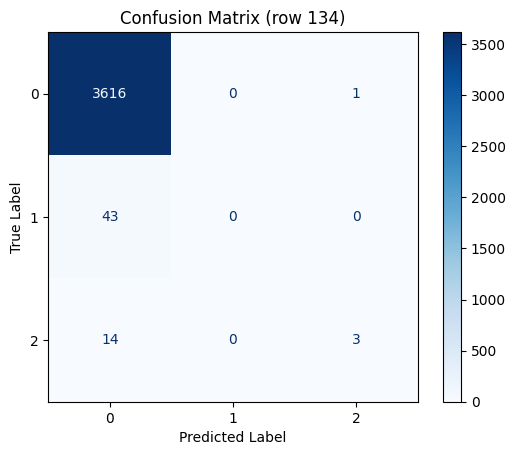

In [239]:
# Compute the confusion matrix
cm = confusion_matrix(true, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (row 134)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### New index (removing row 270)

In [240]:
removed_row_idx = 270

Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
Aij_true = Aij_tensor[removed_row_idx].clone()

#Remove from the dataframe
Aij_train = torch.cat([Aij_tensor[:removed_row_idx], Aij_tensor[removed_row_idx+1:]], dim=0)

#Remove from the feature vector
f_tensor = torch.tensor(feature_vector.values, dtype=torch.float32, device=device)
f_train = torch.cat([f_tensor[:removed_row_idx], f_tensor[removed_row_idx+1:]], dim=0)
f_test = f_tensor[removed_row_idx].unsqueeze(0)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/3719495402.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)


In [241]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_train, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5293
Epoch 1/300, Loss: 3.4885
Epoch 2/300, Loss: 3.4480
Epoch 3/300, Loss: 3.4077
Epoch 4/300, Loss: 3.3680
Epoch 5/300, Loss: 3.3286
Epoch 6/300, Loss: 3.2897
Epoch 7/300, Loss: 3.2514
Epoch 8/300, Loss: 3.2140
Epoch 9/300, Loss: 3.1776
Epoch 10/300, Loss: 3.1419
Epoch 11/300, Loss: 3.1062
Epoch 12/300, Loss: 3.0701
Epoch 13/300, Loss: 3.0334
Epoch 14/300, Loss: 2.9966
Epoch 15/300, Loss: 2.9599
Epoch 16/300, Loss: 2.9236
Epoch 17/300, Loss: 2.8876
Epoch 18/300, Loss: 2.8521
Epoch 19/300, Loss: 2.8171
Epoch 20/300, Loss: 2.7824
Epoch 21/300, Loss: 2.7473
Epoch 22/300, Loss: 2.7113
Epoch 23/300, Loss: 2.6747
Epoch 24/300, Loss: 2.6379
Epoch 25/300, Loss: 2.6015
Epoch 26/300, Loss: 2.5657
Epoch 27/300, Loss: 2.5303
Epoch 28/300, Loss: 2.4953
Epoch 29/300, Loss: 2.4610
Epoch 30/300, Loss: 2.4278
Epoch 31/300, Loss: 2.3955
Epoch 32/300, Loss: 2.3641
Epoch 33/300, Loss: 2.3333
Epoch 34/300, Loss: 2.3033
Epoch 35/300, Loss: 2.2741
Epoch 36/300, Loss: 2.2460
Epoch 37/30

In [242]:
model = EndToEnd(
    feature_mapper=FeatureMapper(input_dim=f_tensor.shape[1], embedding_dim=ldm_trained_r.v.shape[1], start_gamma = gamma),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_train,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    probits = model(f_train, Aij_batch=Aij_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_train)
    loss.backward()
    optimizer.step()


In [243]:
model.eval()
with torch.no_grad():
    probits_pred = model(f_test, predicting=True) 
    predictions = torch.argmax(probits_pred.squeeze(1), dim=0)

In [244]:
true = Aij_true.cpu().numpy()
pred = predictions.cpu().numpy()

mse = mean_squared_error(true, pred)

#count of how many correct links
correct_links = np.sum(pred==true)
total_links = len(true)
accuracy = accuracy_score(true, pred)

print(f"Evaluation for held-out drug:")
print(f"MSE: {mse:.4f}")
print(f"Correct Predictions: {correct_links}/{total_links}")
print(f"Accuracy: {accuracy:.4f}")


Evaluation for held-out drug:
MSE: 0.0359
Correct Predictions: 3657/3677
Accuracy: 0.9946


In [245]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true, pred)) if t != p]
for i in misclassified_indices:
    print(f"True value: {true[i]}, Predicted:{pred[i]}")

True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 3.0, Predicted:0
True value: 3.0, Predicted:0


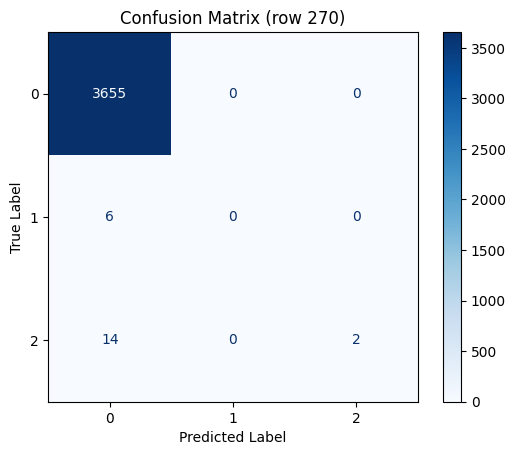

In [246]:
# Compute the confusion matrix
cm = confusion_matrix(true, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (row 270)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### New index (removing row 583)

In [247]:
removed_row_idx = 583

Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)
Aij_true = Aij_tensor[removed_row_idx].clone()

#Remove from the dataframe
Aij_train = torch.cat([Aij_tensor[:removed_row_idx], Aij_tensor[removed_row_idx+1:]], dim=0)

#Remove from the feature vector
f_tensor = torch.tensor(feature_vector.values, dtype=torch.float32, device=device)
f_train = torch.cat([f_tensor[:removed_row_idx], f_tensor[removed_row_idx+1:]], dim=0)
f_test = f_tensor[removed_row_idx].unsqueeze(0)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_29307/3157418326.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Aij_tensor = torch.tensor(Aij_real, dtype=torch.float32, device=device)


In [248]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 15
lr = 0.001
seed = 20
n_epochs = 300
ldm_trained_r = LDM(Aij_train, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

/Users/christine/LatentDistanceModel/latent_distance/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freqs = torch.tensor(self.counts, dtype=torch.float32, device= self.device)


Epoch 0/300, Loss: 3.5269
Epoch 1/300, Loss: 3.4847
Epoch 2/300, Loss: 3.4432
Epoch 3/300, Loss: 3.4022
Epoch 4/300, Loss: 3.3620
Epoch 5/300, Loss: 3.3225
Epoch 6/300, Loss: 3.2839
Epoch 7/300, Loss: 3.2464
Epoch 8/300, Loss: 3.2099
Epoch 9/300, Loss: 3.1743
Epoch 10/300, Loss: 3.1390
Epoch 11/300, Loss: 3.1032
Epoch 12/300, Loss: 3.0671
Epoch 13/300, Loss: 3.0310
Epoch 14/300, Loss: 2.9952
Epoch 15/300, Loss: 2.9599
Epoch 16/300, Loss: 2.9249
Epoch 17/300, Loss: 2.8905
Epoch 18/300, Loss: 2.8565
Epoch 19/300, Loss: 2.8225
Epoch 20/300, Loss: 2.7878
Epoch 21/300, Loss: 2.7521
Epoch 22/300, Loss: 2.7159
Epoch 23/300, Loss: 2.6798
Epoch 24/300, Loss: 2.6439
Epoch 25/300, Loss: 2.6076
Epoch 26/300, Loss: 2.5712
Epoch 27/300, Loss: 2.5355
Epoch 28/300, Loss: 2.5013
Epoch 29/300, Loss: 2.4690
Epoch 30/300, Loss: 2.4385
Epoch 31/300, Loss: 2.4094
Epoch 32/300, Loss: 2.3815
Epoch 33/300, Loss: 2.3542
Epoch 34/300, Loss: 2.3272
Epoch 35/300, Loss: 2.3000
Epoch 36/300, Loss: 2.2728
Epoch 37/30

In [249]:
model = EndToEnd(
    feature_mapper=FeatureMapper(input_dim=f_tensor.shape[1], embedding_dim=ldm_trained_r.v.shape[1], start_gamma = gamma),
    v=ldm_trained_r.v,
    gamma=ldm_trained_r.gamma,
    beta=ldm_trained_r.beta,
    beta_thilde=ldm_trained_r.beta_thilde,
    a=ldm_trained_r.a,
    b=ldm_trained_r.b,
    Aij=Aij_train,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    probits = model(f_train, Aij_batch=Aij_train)
    loss = model.ordinal_cross_entropy_loss(probits, Aij_train)
    loss.backward()
    optimizer.step()


In [250]:
model.eval()
with torch.no_grad():
    probits_pred = model(f_test, predicting=True) 
    predictions = torch.argmax(probits_pred.squeeze(1), dim=0)

In [251]:
true = Aij_true.cpu().numpy()
pred = predictions.cpu().numpy()

mse = mean_squared_error(true, pred)

#count of how many correct links
correct_links = np.sum(pred==true)
total_links = len(true)
accuracy = accuracy_score(true, pred)

print(f"Evaluation for held-out drug:")
print(f"MSE: {mse:.4f}")
print(f"Correct Predictions: {correct_links}/{total_links}")
print(f"Accuracy: {accuracy:.4f}")


Evaluation for held-out drug:
MSE: 0.1428
Correct Predictions: 3548/3677
Accuracy: 0.9649


In [252]:
misclassified_indices = [i for i, (t, p) in enumerate(zip(true, pred)) if t != p]
for i in misclassified_indices:
    print(f"True value: {true[i]}, Predicted:{pred[i]}")

True value: 3.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:3
True value: 3.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.0, Predicted:0
True value: 1.0, Predicted:0
True value: 1.0, Predicted:0
True value: 0.0, Predicted:3
True value: 2.0, Predicted:0
True value: 3.0, Predicted:0
True value: 2.0, Predicted:0
True value: 2.

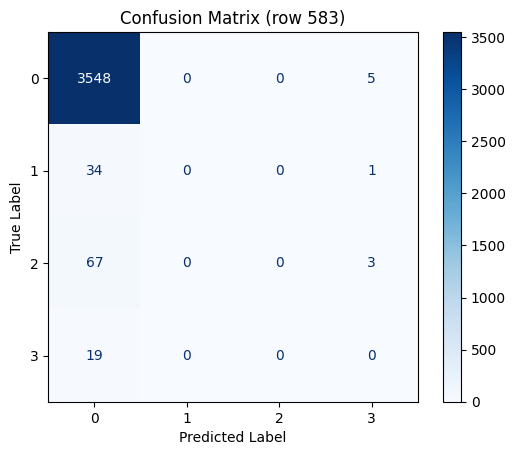

In [253]:
# Compute the confusion matrix
cm = confusion_matrix(true, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (row 583)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [254]:
Aij_real.shape

torch.Size([745, 3677])